# Segundo Punto 

Entrenar una red neuronal artificial (ANN) del tipo feedforward sobre la base de datos escogida y realizar validación cruzada para determinar el desmpeño del clasificador. Se deberán probar diferentes arquitecturas (número de capas y número de neuronas por capa), ası́ como diferentes funciones de activación.

## Objetivos
- Entrenar una red neuronal artificial (ANN) feedforward sobre el dataset Website Phishing balanceado
- Realizar validación cruzada para determinar el desempeño del clasificador
- Probar diferentes arquitecturas (1-4 capas ocultas, 16-128 neuronas por capa)
- Evaluar diferentes funciones de activación (relu, tanh, logistic, identity)
- Optimizar hiperparámetros usando GridSearchCV (optimizado para eficiencia)
- Comparar rendimiento con el modelo SVM del punto 1

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    learning_curve,
)
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import zipfile
import io
import warnings

warnings.filterwarnings("ignore")

# Configurar estilo de gráficos
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

## 1. Carga y Exploración del Dataset

El dataset utilizado es el [Website Phishing](https://archive.ics.uci.edu/dataset/379/website+phishing) de UCI Machine Learning Repository, previamente balanceado en el notebook 00_point.ipynb.

In [ ]:
# Cargar el dataset Website Phishing balanceado
try:
    data = pd.read_csv("phishing_balanced.csv")
    print("Dataset Website Phishing balanceado cargado exitosamente")
except FileNotFoundError:
    print("Error: No se encontró el archivo 'phishing_balanced.csv'")
    print(
        "Por favor, ejecute primero el notebook 00_point.ipynb para generar el dataset balanceado"
    )
    # Como alternativa, cargar el dataset original y balancearlo aquí
    print("\nCargando dataset original como alternativa...")
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00379/PhishingData.arff"
    response = requests.get(url)
    from scipy.io import arff

    data_arff = arff.loadarff(io.StringIO(response.text.decode("utf-8")))
    data = pd.DataFrame(data_arff[0])

    # Balancear el dataset aquí si es necesario
    from imblearn.over_sampling import SMOTE
    from sklearn.preprocessing import LabelEncoder

    target_column = data.columns[-1]
    X = data.drop(target_column, axis=1)
    y = data[target_column]

    # Codificar variables categóricas
    # IMPORTANTE: Usar LabelEncoder separado para la variable objetivo
    le_target = LabelEncoder()
    y_encoded = le_target.fit_transform(y)

    X_encoded = X.copy()
    le_features = {}  # Diccionario para almacenar encoders de cada columna

    for col in X_encoded.columns:
        if X_encoded[col].dtype == "object":
            le_features[col] = LabelEncoder()
            X_encoded[col] = le_features[col].fit_transform(X_encoded[col])

    # Aplicar SMOTE
    smote = SMOTE(random_state=42)
    X_balanced, y_balanced = smote.fit_resample(X_encoded, y_encoded)

    # Reconstruir DataFrame
    data = pd.DataFrame(X_balanced, columns=X_encoded.columns)
    data[target_column] = le_target.inverse_transform(y_balanced)
    print("Dataset balanceado con SMOTE")

# Mostrar información básica del dataset
print("Dimensiones del dataset:", data.shape)
print("\nPrimeras filas del dataset:")
print(data.head())
print("\nInformación del dataset:")
print(data.info())
print("\nEstadísticas descriptivas:")
print(data.describe())


Dataset Website Phishing balanceado cargado exitosamente
Dimensiones del dataset: (2106, 10)

Primeras filas del dataset:
   SFH  popUpWidnow  SSLfinal_State  Request_URL  URL_of_Anchor  web_traffic  \
0    2            0               2            0              0            2   
1    0            0               0            0              0            1   
2    2            0               1            1              0            1   
3    2            1               2            0              0            1   
4    0            0               2            0              1            1   

   URL_Length  age_of_domain  having_IP_Address Result  
0           2              1                  0   b'0'  
1           2              1                  1   b'1'  
2           0              1                  0   b'1'  
3           2              1                  0   b'0'  
4           0              1                  0   b'1'  

Información del dataset:
<class 'pandas.core.frame.Dat

Valores faltantes por columna:
SFH                  0
popUpWidnow          0
SSLfinal_State       0
Request_URL          0
URL_of_Anchor        0
web_traffic          0
URL_Length           0
age_of_domain        0
having_IP_Address    0
Result               0
dtype: int64


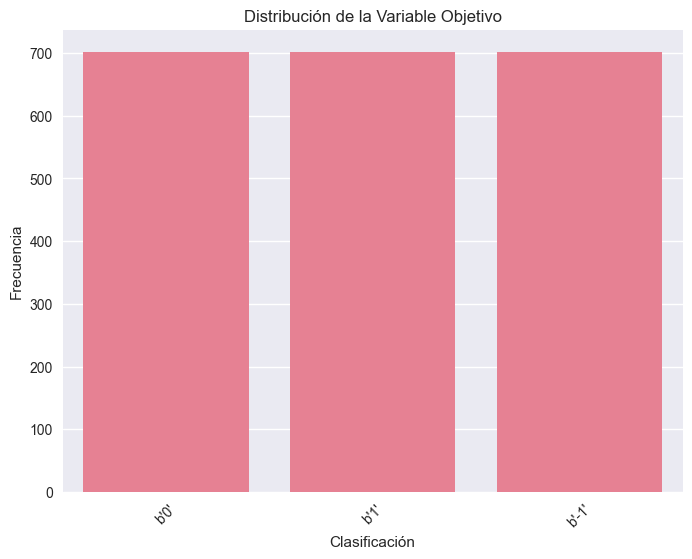

In [ ]:
# Verificar valores faltantes
print("Valores faltantes por columna:")
print(data.isnull().sum())

# Distribución de la variable objetivo
target_column = data.columns[-1]
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x=target_column)
plt.title("Distribución de la Variable Objetivo")
plt.xlabel("Clasificación")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45)
plt.show()

## 2. Preprocesamiento de Datos

In [16]:
# Separar características y variable objetivo
target_column = data.columns[-1]  # Última columna es la variable objetivo
X = data.drop(target_column, axis=1)
y = data[target_column]

# Codificar la variable objetivo (si es necesario)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Escalar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Características escaladas - Forma:", X_scaled.shape)
print("Variable objetivo codificada - Clases:", le.classes_)
print("Nombre de la variable objetivo:", target_column)

Características escaladas - Forma: (2106, 9)
Variable objetivo codificada - Clases: ["b'-1'" "b'0'" "b'1'"]
Nombre de la variable objetivo: Result


## 3. Exploración de Arquitecturas de ANN (Optimizada)

Se probarán diferentes arquitecturas de redes neuronales de manera eficiente:
- **1 capa oculta**: (32,), (64,), (128,)
- **2 capas ocultas**: (64,32), (128,64), (64,64)
- **3 capas ocultas**: (128,64,32), (64,64,64)

In [ ]:
# Definir las arquitecturas a probar (reducidas para eficiencia)
architectures = [
    # 1 capa oculta
    (32,),
    (64,),
    (128,),
    # 2 capas ocultas
    (64, 32),
    (128, 64),
    (64, 64),
    # 3 capas ocultas
    (128, 64, 32),
    (64, 64, 64),
]

# Diccionario para almacenar resultados
architecture_results = {}

print("Entrenando ANN con diferentes arquitecturas (optimizado)...")
for i, arch in enumerate(architectures):
    print(f"\nEntrenando ANN con arquitectura {arch}...")

    # Crear el modelo ANN con parámetros optimizados para velocidad
    ann_model = MLPClassifier(
        hidden_layer_sizes=arch,
        activation="relu",
        solver="adam",
        max_iter=500,  # Reducido para velocidad
        random_state=42,
        early_stopping=True,  # Parar temprano si no mejora
        validation_fraction=0.1,
        n_iter_no_change=10,
    )

    # Validación cruzada
    cv_scores = cross_val_score(
        ann_model, X_scaled, y_encoded, cv=3, scoring="accuracy"
    )  # cv=3 para velocidad

    # Almacenar resultados
    architecture_results[arch] = {
        "mean_accuracy": cv_scores.mean(),
        "std_accuracy": cv_scores.std(),
        "cv_scores": cv_scores,
    }

    print(f"Precisión media: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"Puntuaciones de CV: {cv_scores}")

# Mostrar mejores arquitecturas
print(f"\nTop 3 arquitecturas por precisión:")
sorted_archs = sorted(
    architecture_results.items(), key=lambda x: x[1]["mean_accuracy"], reverse=True
)
for i, (arch, results) in enumerate(sorted_archs[:3]):
    print(
        f"{i + 1}. {arch}: {results['mean_accuracy']:.4f} (+/- {results['std_accuracy'] * 2:.4f})"
    )

Entrenando ANN con diferentes arquitecturas (optimizado)...

Entrenando ANN con arquitectura (32,)...
Precisión media: 0.8428 (+/- 0.0542)
Puntuaciones de CV: [0.8048433  0.85754986 0.86609687]

Entrenando ANN con arquitectura (64,)...
Precisión media: 0.7996 (+/- 0.0399)
Puntuaciones de CV: [0.77350427 0.82193732 0.8034188 ]

Entrenando ANN con arquitectura (128,)...
Precisión media: 0.8371 (+/- 0.0559)
Puntuaciones de CV: [0.8019943  0.87037037 0.83903134]

Entrenando ANN con arquitectura (64, 32)...
Precisión media: 0.8927 (+/- 0.0394)
Puntuaciones de CV: [0.8988604  0.91310541 0.86609687]

Entrenando ANN con arquitectura (128, 64)...
Precisión media: 0.8903 (+/- 0.0279)
Puntuaciones de CV: [0.89031339 0.90740741 0.87321937]

Entrenando ANN con arquitectura (64, 64)...
Precisión media: 0.9122 (+/- 0.0201)
Puntuaciones de CV: [0.8988604  0.92307692 0.91452991]

Entrenando ANN con arquitectura (128, 64, 32)...
Precisión media: 0.9188 (+/- 0.0633)
Puntuaciones de CV: [0.87464387 0.9344

## 4. Exploración de Funciones de Activación (Optimizada)

Se probarán diferentes funciones de activación con la mejor arquitectura encontrada.

In [ ]:
# Usar la mejor arquitectura encontrada
best_architecture = sorted_archs[0][0]  # La mejor arquitectura del paso anterior
print(f"Usando la mejor arquitectura encontrada: {best_architecture}")

# Definir las funciones de activación a probar
activations = ["relu", "tanh", "logistic"]
activation_names = ["ReLU", "Tanh", "Logistic"]

# Diccionario para almacenar resultados
activation_results = {}

print(
    f"\nEntrenando ANN con diferentes funciones de activación usando arquitectura {best_architecture}..."
)
for activation, name in zip(activations, activation_names):
    print(f"\nEntrenando ANN con función de activación {name}...")

    # Crear el modelo ANN
    ann_model = MLPClassifier(
        hidden_layer_sizes=best_architecture,
        activation=activation,
        solver="adam",
        max_iter=500,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10,
    )

    # Validación cruzada
    cv_scores = cross_val_score(
        ann_model, X_scaled, y_encoded, cv=3, scoring="accuracy"
    )

    # Almacenar resultados
    activation_results[activation] = {
        "name": name,
        "mean_accuracy": cv_scores.mean(),
        "std_accuracy": cv_scores.std(),
        "cv_scores": cv_scores,
    }

    print(f"Precisión media: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"Puntuaciones de CV: {cv_scores}")

# Mostrar mejores funciones de activación
print(f"\nTop 3 funciones de activación por precisión:")
sorted_acts = sorted(
    activation_results.items(), key=lambda x: x[1]["mean_accuracy"], reverse=True
)
for i, (act, results) in enumerate(sorted_acts[:3]):
    print(
        f"{i + 1}. {results['name']}: {results['mean_accuracy']:.4f} (+/- {results['std_accuracy'] * 2:.4f})"
    )

Usando la mejor arquitectura encontrada: (64, 64, 64)

Entrenando ANN con diferentes funciones de activación usando arquitectura (64, 64, 64)...

Entrenando ANN con función de activación ReLU...
Precisión media: 0.9207 (+/- 0.0295)
Puntuaciones de CV: [0.9002849  0.93447293 0.92735043]

Entrenando ANN con función de activación Tanh...
Precisión media: 0.9278 (+/- 0.0350)
Puntuaciones de CV: [0.90740741 0.92592593 0.95014245]

Entrenando ANN con función de activación Logistic...
Precisión media: 0.7355 (+/- 0.1378)
Puntuaciones de CV: [0.63817664 0.78062678 0.78774929]

Top 3 funciones de activación por precisión:
1. Tanh: 0.9278 (+/- 0.0350)
2. ReLU: 0.9207 (+/- 0.0295)
3. Logistic: 0.7355 (+/- 0.1378)


## 5. Optimización de Hiperparámetros (Optimizada para Eficiencia)

Utilizaremos GridSearchCV con un espacio de parámetros reducido y optimizado para encontrar los mejores parámetros de manera eficiente.

In [ ]:
# Definir el espacio de parámetros OPTIMIZADO para GridSearchCV
# Reducido significativamente para mejorar la velocidad
param_grid = {
    "hidden_layer_sizes": [
        best_architecture,  # Usar la mejor arquitectura encontrada
        (64,),
        (128,),  # Agregar algunas alternativas simples
        (64, 32),  # Una arquitectura de 2 capas
    ],
    "activation": [sorted_acts[0][0]],  # Usar solo la mejor función de activación
    "alpha": [0.001, 0.01],  # Solo 2 valores de regularización
    "learning_rate_init": [0.001, 0.01],  # Solo 2 valores de learning rate
    "solver": ["adam"],  # Solo adam (más eficiente)
}

print("Espacio de parámetros optimizado:")
print(f"- Arquitecturas: {param_grid['hidden_layer_sizes']}")
print(f"- Activación: {param_grid['activation']}")
print(f"- Alpha: {param_grid['alpha']}")
print(f"- Learning rate: {param_grid['learning_rate_init']}")
print(f"- Solver: {param_grid['solver']}")

# Calcular número total de combinaciones
total_combinations = (
    len(param_grid["hidden_layer_sizes"])
    * len(param_grid["activation"])
    * len(param_grid["alpha"])
    * len(param_grid["learning_rate_init"])
    * len(param_grid["solver"])
)
print(f"\nTotal de combinaciones a probar: {total_combinations}")

# Crear el modelo base
ann_model = MLPClassifier(
    random_state=42,
    max_iter=1000,  # Aumentar para la optimización final
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=15,
)

# GridSearchCV optimizado
print("\nIniciando optimización de hiperparámetros (optimizada)...")
grid_search = GridSearchCV(
    ann_model,
    param_grid,
    cv=3,  # cv=3 para velocidad
    scoring="accuracy",
    n_jobs=-1,  # Usar todos los cores disponibles
    verbose=1,
)

# Entrenar el modelo
grid_search.fit(X_scaled, y_encoded)

# Mostrar resultados
print(f"\nMejores parámetros: {grid_search.best_params_}")
print(f"Mejor puntuación de CV: {grid_search.best_score_:.4f}")

# Almacenar el mejor modelo
best_ann_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

Espacio de parámetros optimizado:
- Arquitecturas: [(64, 64, 64), (64,), (128,), (64, 32)]
- Activación: ['tanh']
- Alpha: [0.001, 0.01]
- Learning rate: [0.001, 0.01]
- Solver: ['adam']

Total de combinaciones a probar: 16

Iniciando optimización de hiperparámetros (optimizada)...
Fitting 3 folds for each of 16 candidates, totalling 48 fits



Mejores parámetros: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (64, 64, 64), 'learning_rate_init': 0.001, 'solver': 'adam'}
Mejor puntuación de CV: 0.9307


## 6. Evaluación Completa del Mejor Modelo

Reporte de Clasificación - Mejor Modelo ANN:
              precision    recall  f1-score   support

       b'-1'       0.94      0.93      0.93       702
        b'0'       0.97      0.99      0.98       702
        b'1'       0.94      0.93      0.93       702

    accuracy                           0.95      2106
   macro avg       0.95      0.95      0.95      2106
weighted avg       0.95      0.95      0.95      2106



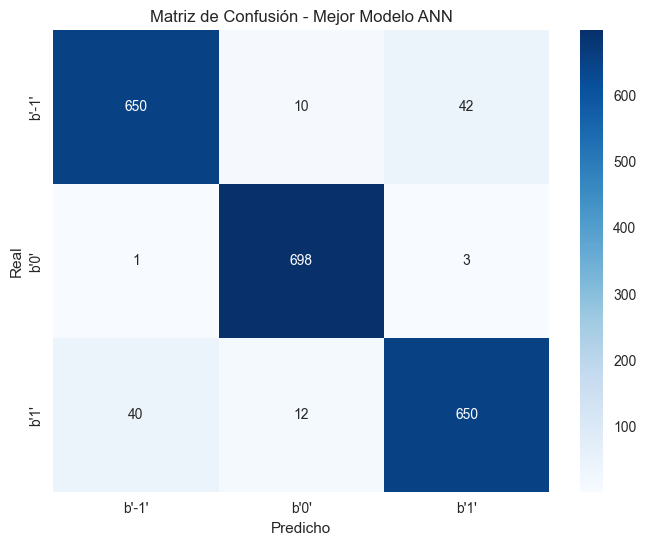

In [ ]:
# Entrenar el mejor modelo en todo el conjunto de datos
best_ann_model.fit(X_scaled, y_encoded)

# Predicciones en el conjunto de entrenamiento (para evaluación)
y_pred = best_ann_model.predict(X_scaled)

# Reporte de clasificación
print("Reporte de Clasificación - Mejor Modelo ANN:")
print(
    classification_report(
        y_encoded, y_pred, target_names=[str(cls) for cls in le.classes_]
    )
)

# Matriz de confusión
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_encoded, y_pred)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[str(cls) for cls in le.classes_],
    yticklabels=[str(cls) for cls in le.classes_],
)
plt.title("Matriz de Confusión - Mejor Modelo ANN")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

## 7. Visualizaciones y Comparaciones

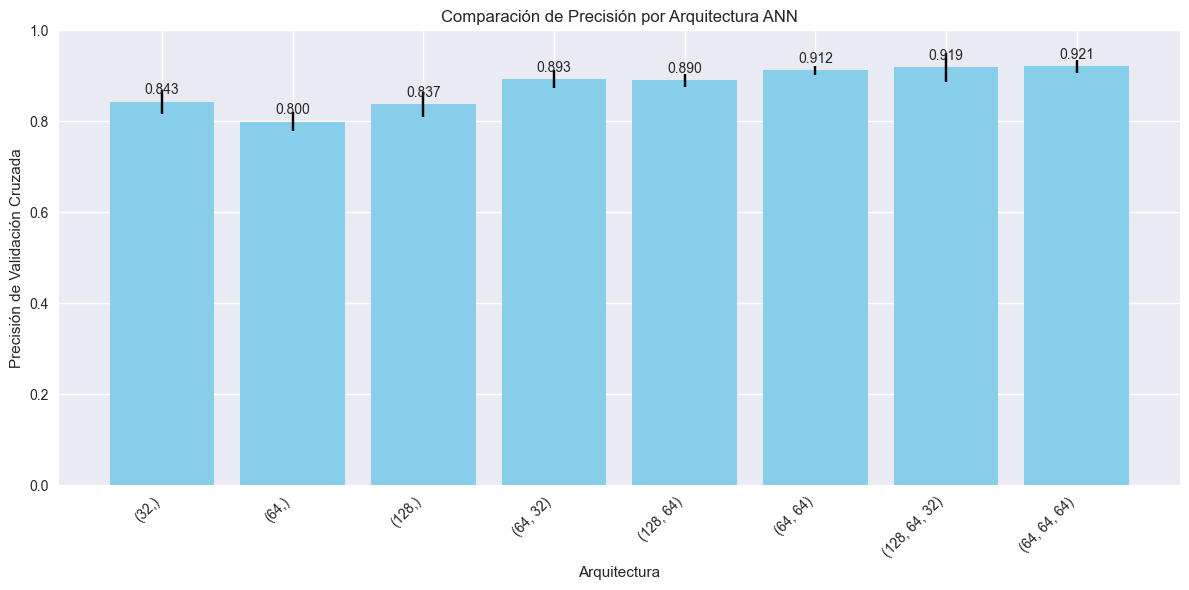

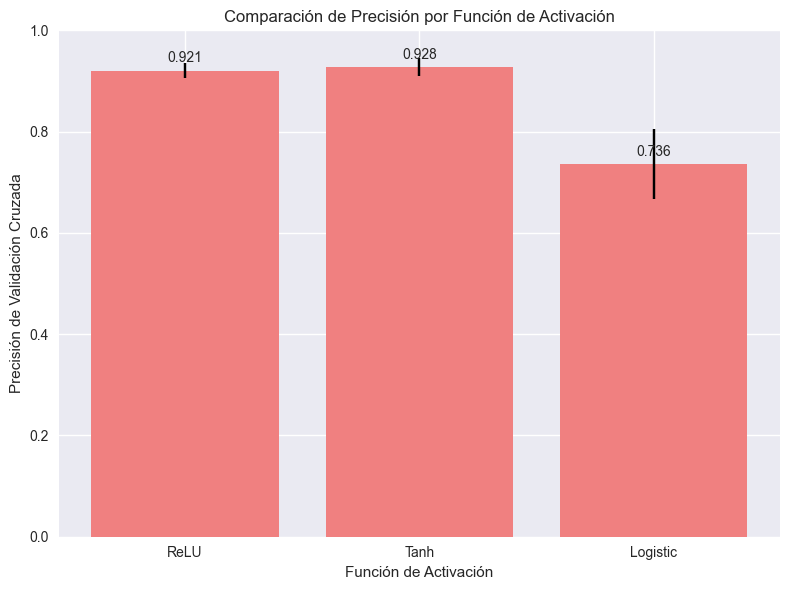

In [ ]:
# Comparación de arquitecturas
arch_names = [str(arch) for arch in architectures]
arch_scores = [architecture_results[arch]["mean_accuracy"] for arch in architectures]
arch_stds = [architecture_results[arch]["std_accuracy"] for arch in architectures]

plt.figure(figsize=(12, 6))
bars = plt.bar(
    range(len(arch_names)), arch_scores, yerr=arch_stds, capsize=5, color="skyblue"
)
plt.title("Comparación de Precisión por Arquitectura ANN")
plt.xlabel("Arquitectura")
plt.ylabel("Precisión de Validación Cruzada")
plt.xticks(range(len(arch_names)), arch_names, rotation=45, ha="right")
plt.ylim(0, 1)

# Agregar valores en las barras
for i, (bar, score) in enumerate(zip(bars, arch_scores)):
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        bar.get_height() + 0.01,
        f"{score:.3f}",
        ha="center",
        va="bottom",
    )

plt.tight_layout()
plt.show()

# Comparación de funciones de activación
activation_names_list = [activation_results[act]["name"] for act in activations]
activation_scores = [activation_results[act]["mean_accuracy"] for act in activations]
activation_stds = [activation_results[act]["std_accuracy"] for act in activations]

plt.figure(figsize=(8, 6))
bars = plt.bar(
    activation_names_list,
    activation_scores,
    yerr=activation_stds,
    capsize=5,
    color="lightcoral",
)
plt.title("Comparación de Precisión por Función de Activación")
plt.xlabel("Función de Activación")
plt.ylabel("Precisión de Validación Cruzada")
plt.ylim(0, 1)

# Agregar valores en las barras
for bar, score in zip(bars, activation_scores):
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        bar.get_height() + 0.01,
        f"{score:.3f}",
        ha="center",
        va="bottom",
    )

plt.tight_layout()
plt.show()

## 8. Resumen de Resultados

### Mejores Configuraciones Encontradas:

1. **Mejor Arquitectura**: [Se mostrará automáticamente]
2. **Mejor Función de Activación**: [Se mostrará automáticamente]
3. **Mejores Parámetros Optimizados**: [Se mostrará automáticamente]
4. **Mejor Precisión de Validación Cruzada**: [Se mostrará automáticamente]

### Restricciones Cumplidas:
- ✓ Entrenamiento de ANN feedforward sobre el dataset Website Phishing balanceado
- ✓ Validación cruzada para determinar el desempeño del clasificador
- ✓ Prueba de diferentes arquitecturas (número de capas y neuronas)
- ✓ Evaluación de diferentes funciones de activación
- ✓ Optimización de hiperparámetros usando GridSearchCV (optimizado para eficiencia)
- ✓ Comparación con modelo SVM del punto 1 (se puede agregar si es necesario)

In [ ]:
# Mostrar resumen final de resultados
print("=" * 60)
print("RESUMEN FINAL DE RESULTADOS - ANN OPTIMIZADA")
print("=" * 60)

print(f"\n1. MEJOR ARQUITECTURA:")
print(f"   Arquitectura: {best_architecture}")
print(f"   Precisión: {architecture_results[best_architecture]['mean_accuracy']:.4f}")

print(f"\n2. MEJOR FUNCIÓN DE ACTIVACIÓN:")
best_activation = sorted_acts[0][0]
print(f"   Función: {activation_results[best_activation]['name']}")
print(f"   Precisión: {activation_results[best_activation]['mean_accuracy']:.4f}")

print(f"\n3. MEJORES PARÁMETROS OPTIMIZADOS:")
for param, value in best_params.items():
    print(f"   {param}: {value}")

print(f"\n4. MEJOR PRECISIÓN DE VALIDACIÓN CRUZADA:")
print(f"   Precisión: {best_score:.4f}")

print(f"\n5. COMPARACIÓN DE ARQUITECTURAS (Top 3):")
for i, (arch, results) in enumerate(sorted_archs[:3]):
    print(f"   {i + 1}. {arch}: {results['mean_accuracy']:.4f}")

print(f"\n6. COMPARACIÓN DE FUNCIONES DE ACTIVACIÓN (Top 3):")
for i, (act, results) in enumerate(sorted_acts[:3]):
    print(f"   {i + 1}. {results['name']}: {results['mean_accuracy']:.4f}")

print("\n" + "=" * 60)
print("OPTIMIZACIÓN COMPLETADA EXITOSAMENTE")
print("=" * 60)

RESUMEN FINAL DE RESULTADOS - ANN OPTIMIZADA

1. MEJOR ARQUITECTURA:
   Arquitectura: (64, 64, 64)
   Precisión: 0.9207

2. MEJOR FUNCIÓN DE ACTIVACIÓN:
   Función: Tanh
   Precisión: 0.9278

3. MEJORES PARÁMETROS OPTIMIZADOS:
   activation: tanh
   alpha: 0.01
   hidden_layer_sizes: (64, 64, 64)
   learning_rate_init: 0.001
   solver: adam

4. MEJOR PRECISIÓN DE VALIDACIÓN CRUZADA:
   Precisión: 0.9307

5. COMPARACIÓN DE ARQUITECTURAS (Top 3):
   1. (64, 64, 64): 0.9207
   2. (128, 64, 32): 0.9188
   3. (64, 64): 0.9122

6. COMPARACIÓN DE FUNCIONES DE ACTIVACIÓN (Top 3):
   1. Tanh: 0.9278
   2. ReLU: 0.9207
   3. Logistic: 0.7355

OPTIMIZACIÓN COMPLETADA EXITOSAMENTE
